# Email Tracking BOT Detection - Data Exploration

![alt text](Diagrams/Tracking.png "Tracking Overview") 

More and more, email tracking data is originating from BOT activity as opposed to the actual person the email is intended for.  Through manual investigation, most of these bots are not malicious, but come from protective services like Anti-Phishing devices meant to protect the email contact from dangerous emails.  

The goal is not to reject requests from known BOTS.  We still want these protective services to see the links and to be able to judge the safety of the email message.  But if we can predict if the request is from one of these BOT services, we could mark or discard the activity to prevent skewing of activity reporting on the campaign.

## Terminology
- **Subscriber List** - A list of email addresses that have opted into receiving emails from the company.  A list have have many emails.  A company can have many subscriber lists.  An email can belong to many lists and many companies.  But a subscriber list can only belong to one company.
- **Campaign** - An email message send out by a company.  This email is sent to some or all the subscribers on the list.  With the exception of some limited personalization, all subscribed receive the same content.  A list can have many campaigns, but a campaign can only have one subscriber list.
- **Inbox** - What the contact sees as a unique message in their inbox (Outlook, GMail, etc.).  If a company sends a single campaign to 1 million contacts, there will be 1 million InboxIDs for that campaign.
- **Request** - A tracking HTTP request from an action the contact takes on a message in their inbox.  There are several types of requests, but they are primarily Opens which are pixel image reqeusts and Clicks.
- **Link** - A clickable and trackable URL embedded in the email message.  The tracking system identifies the click, saved the tracking information and returns a redirect URL so the contact gets to their intended URL destination.
- **AS Number/Name** - Who owns the block of IP address.  https://en.wikipedia.org/wiki/Autonomous_system_(Internet)
- **CIDR** - A notation of shows us what range of IP address are in a block. https://en.wikipedia.org/wiki/Classless_Inter-Domain_Routing


## Columns 

 #### Raw columns recieved with HTTP Request:
 
 - **InboxID** - Uniquely identifies the Campaign and the email it was sent to.
 - **Company** - Who owns the campaign
 - **RequestType** - 
     - *Open* - The contact downloaded images for the message.  A tracking pixel added to the HTML body of the message makes a request to the tracking system to identify who opened the message.
     - *Read* - The message was opened for a pre-defined period of time.
     - *Click* - The contact clicked on a URL in the message and the tracking system sees this request.
     - *Browser Link* - The contact requested seeing the message in a web browser.  Mostly used if the message did not render well in the email client.
 - **RequestDate** - The date of the reqeust (i.e. Open or Click).
 - **Link** - A hash of the URL requested.
 - **IPAddress** - The IP Address the requested was generated from.
 - **UserAgent** - A string submitted by email clients/browsers and Bots that attempts to identify the browser type.  This can be made any string you want to it can be easily modified by Bots.
 
 
 #### Columns that can be looked up from the InboxID: 
 
 - **SendDate** - The date and time (1 minute precision) of when the message was sent to that email.  If a company sends a campaign to 5 million email, the send might take 10-20 mins.  The SendDate is the date when that message was sent out and not the date the campaign started.
 - **List** - A unique ID of the subscription list.  
 - **Campaign** - A unique ID of the campaign.
 - **UserID** - A unique ID of the email address the message was sent to.
 - **DomainID** - A unique ID of the domain of the email address the message was sent to.
 - **EmailDomain** (redundant with DomainID)- A unique ID of the domain of the email address the message was sent to.
 - **EmailRootLevelDomain** - The top level domain of the email domain.  i.e. fred@gamil.com - ".com", mary@harvard.edu - 
 
 
 #### Columns that are derived from IP lookup data:
 
 - **AS Name** - Owner of the IP Range (see above).  Can be Null if owner not found in ASN database.
 - **AS Number** - Owner of the IP Range (see above).  Can be Null if owner not found in ASN database.
 - **CIDR Range** - The block the IPAddress belongs to (see above).  Can be Null if owner not found in ASN database.".edu"
 - **Lat/Long** - Found from an IP Lookup service.  Data available is not center of mass, but just the first Lat/Log in the polygon.
 - **OlsonName** - Time Zone of the location the request came from. Also found via the IP Lookup.
 
#### Cacluated columns after InboxID lookup is performed
 
 - **SendRequestSeconds** - Number of seconds between the time the message was sent to the request date..


 ## Hierarchies in Data
 
 ![alt text](Diagrams/Hierarchies.png "Hierarchies in Data")

In [1]:
import numpy as np
from collections import defaultdict
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta
import pytz
from dateutil.tz import tzutc
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import os.path
from os import path
import pickle

### BotDataSet Class

We will use a class to make sure the **loading**, **cleanup** and **sessionization** is done consistantly for both the IP Reputation and the Campaing dataset.  This class will also give us code reuse for the trainging and testing datasets.

In [2]:
exec(open("BotDataSet.py").read())

In [3]:
botDataSet = BotDataSet()
botDataSet.loadCSV('C:/data/2020-01-17.csv')
df = botDataSet.df

In [4]:
pd.options.display.max_columns = None
display(df.head()) 
print(df.shape)
print('RequestDate Range: {}:{}'.format(df['RequestDate'].min(), df['RequestDate'].max()))
df.nunique()

,InboxID,Company,List,Campaign,RequestType,SendDate,RequestDate,Link,IPAddress,UserAgent,AS Name,AS Number,CIDR Range,UserID,DomainID,EmailDomain,EmailRootLevelDomain,CountryCode,RegionCode,PostalCode,Lat,Long,OlsonName,SendRequestSeconds,SendRequestSeconds_ln
0,{7C9E652E-AC29-02E0-BE9A-8C43363D665E},{0F96A485-3307-02C7-6F5F-C23BAF3CB945},{79575937-FEB1-AD59-92A5-F2BDCD8EBE25},{4ECAB404-363D-958D-4ECB-99B8D565A66E},Click,2020-01-16 11:32:00,2020-01-16 22:33:00,{CB7A65D9-3644-5395-6E60-E7A556F52E3A},{98302769-08A3-76D3-A660-FB0ED5A313CF},{1047A34C-F98E-2B84-9E69-BCBA6FEEDA97},Unknown,Unknown,{14392925-2BAF-FC72-0602-9DB674D6E74D},{C69692BD-C245-842F-7E3A-0BD44C2E52E8},{9DB20ACE-264D-4774-240E-A86A9FEBC3E6},{5236C5C5-F807-01B8-7308-6369971DE796},.au,AU,05,5000,NaN,NaN,Australia/Adelaide,39660,10.588167
1,{5C245764-B2E8-6C22-65DA-2FA633D2B83D},{30ADEAEA-4CB8-2254-1AD2-0D76721A3895},{D79E0F2C-4B46-F92F-513C-D9CB4D8150C6},{8708F19F-4880-FA0F-ECCC-0656BDE3B75C},Click,2020-01-17 00:51:00,2020-01-17 04:36:00,{3536BC26-72F7-93D0-09EF-2BF0D5BF5C56},{F879CD11-C8A8-E0F2-A6CF-FFD517892C2D},{67293EF8-7DAD-4A39-0C54-A4499B81C1B0},Unknown,Unknown,{14392925-2BAF-FC72-0602-9DB674D6E74D},{D2D2EECD-86A8-F45B-58AF-ED5ECF0025B6},{7C1BFAEE-63CC-62EB-7343-BB54BBB09F34},{8BBE6FB8-C8D7-CFA8-BF17-AD7BAE195985},.com,AU,05,5000,NaN,NaN,Australia/Adelaide,13500,9.510646
2,{8AB62ABA-0FFD-E217-7EBD-8AD7ECC87559},{30ADEAEA-4CB8-2254-1AD2-0D76721A3895},{E46FC402-5D7C-CB5B-0341-30AC5C9E30C6},{2DFC70F3-E099-652B-A336-E7A215899841},Click,2020-01-16 08:49:00,2020-01-16 19:50:00,{980DC05A-AA27-25B7-7E63-71E70A813088},{7B8A27E6-F6AB-6573-BEF3-334E2E442EF5},{4B0814A1-D331-7033-76B6-F8DB28419C4E},Unknown,Unknown,{14392925-2BAF-FC72-0602-9DB674D6E74D},{07C40EB6-8768-1646-A917-110882272065},{7C1BFAEE-63CC-62EB-7343-BB54BBB09F34},{8BBE6FB8-C8D7-CFA8-BF17-AD7BAE195985},.com,AU,05,5000,NaN,NaN,Australia/Adelaide,39660,10.588167
3,{4DE4BB44-5B00-C6E0-3164-C861E43F0C62},{30ADEAEA-4CB8-2254-1AD2-0D76721A3895},{E46FC402-5D7C-CB5B-0341-30AC5C9E30C6},{ED6C0505-90EC-C31C-3A6A-70A4A193A848},Click,2020-01-16 09:03:00,2020-01-16 17:27:00,{22792626-F2A9-D1AF-AB10-413C1F949A6A},{AF6309B4-2BB3-A707-2F53-131B8DC1D6A4},{F87DC183-2EAD-5AED-B536-4545C440750D},Unknown,Unknown,{14392925-2BAF-FC72-0602-9DB674D6E74D},{59591E4C-6446-5D8C-B4BB-FE284BEC8716},{355469F6-693A-48D0-ACF7-772342C94F4E},{E1EB2A3A-3A96-7B63-669B-7BF029316F88},.com,AU,08,6000,NaN,NaN,Australia/Perth,30240,10.317011
4,{ECB3FB8D-CBA3-8EB3-B97A-88C776102D97},{30ADEAEA-4CB8-2254-1AD2-0D76721A3895},{E46FC402-5D7C-CB5B-0341-30AC5C9E30C6},{2DFC70F3-E099-652B-A336-E7A215899841},Click,2020-01-16 08:48:00,2020-01-16 21:13:00,{93D6CA84-1DFF-2FC5-A0B1-FAB6DE900639},{BB083DCF-AABB-3B20-FB03-6F9DD69BABBE},{F87DC183-2EAD-5AED-B536-4545C440750D},Unknown,Unknown,{14392925-2BAF-FC72-0602-9DB674D6E74D},{ED8E3431-6480-D006-1DFC-4F1BFE952B03},{D75C365A-E14F-D786-8B90-F5AE2456FC87},{FED8E0A7-B13C-C044-F0EB-67C14E5F143D},.com,AU,08,6000,NaN,NaN,Australia/Perth,44700,10.707790


(101061, 25)
RequestDate Range: 2020-01-16 09:00:00:2020-01-17 09:00:00


InboxID                  60675
Company                     27
List                        94
Campaign                  1033
RequestType                  1
SendDate                  5411
RequestDate               1441
Link                      5678
IPAddress                55248
UserAgent                 3917
AS Name                     24
AS Number                   25
CIDR Range                 908
UserID                   56880
DomainID                  5581
EmailDomain               5581
EmailRootLevelDomain        90
CountryCode                182
RegionCode                 202
PostalCode                7513
Lat                       4016
Long                      4195
OlsonName                  146
SendRequestSeconds        9018
SendRequestSeconds_ln     9018
dtype: int64

# Only One Metrizable Column in Raw Request Data
## But this metric is one of the major factors that we anticipate will help us identify BOTs.

Mose of the click BOTs are safty devices that examin the risk of the email before it is released to the contact's inbox. So to prevent causing a long delay, the BOTs will want to process the links as soon as they are recieved.  Through manual, most of the suspected BOTs click the message within 1 or 2 minutes after send went out.

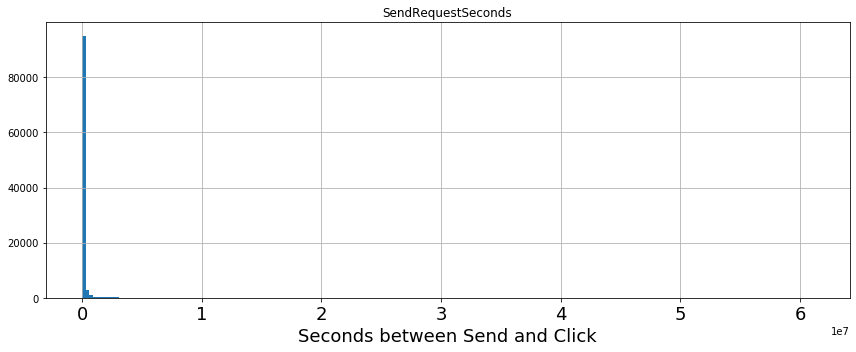

In [5]:
df.hist(column='SendRequestSeconds', bins=200, figsize=(12,5), xlabelsize=18)
plt.xlabel("Seconds between Send and Click", fontsize=18)
plt.tight_layout()
plt.show()

## As you can see from the histogram, there is an overwelming number of clicks in the first few minusts after the send.

#### To even out this distribution, the BotDataSet class created a calculated column called **SendRequestSeconds_ln**

This was done by taking the natural log of the SendRequestSeconds.  To avoid zero and negative, the number e was added before the the log was taking.  This make the bottom of the scale = 1.  To give a feel of the upper limit of the this value, 2 days (172800 seconds) would give a value of 14.77.

## $ SendRequestSeconds\_ln = log_{e}(SendRequestSeconds + e) $

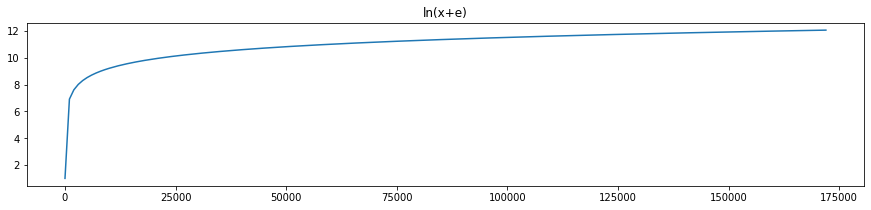

In [6]:
def ln_seconds_plus_e(t):
    return np.log(t + np.exp(1)) 
seconds = range(0, 172800, 1000)
seconds_ln =  ln_seconds_plus_e(seconds)
f = plt.figure(figsize=(15, 3))
plt.plot(seconds, seconds_ln)
plt.title('ln(x+e)')
plt.show()

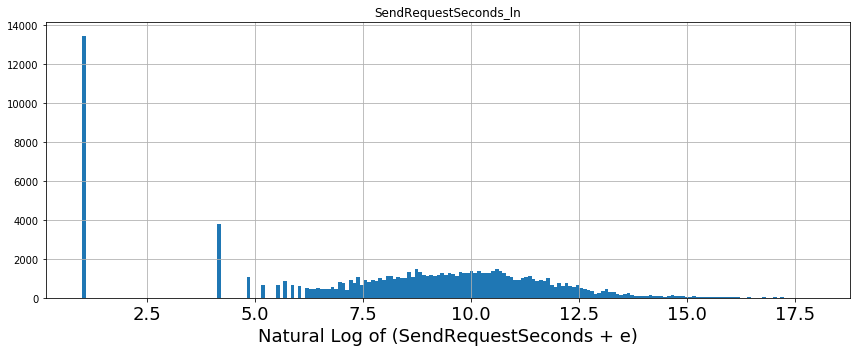

In [7]:
df.hist(column='SendRequestSeconds_ln', bins=200, figsize=(12,5), xlabelsize=18)
plt.xlabel("Natural Log of (SendRequestSeconds + e)", fontsize=18)
plt.tight_layout()
plt.show()

# Sessionization

Making assessments from individual requests may not be as informative as grouping requests together.  It is common for a single InboxID to have multiple requests (i.e. click 3 links on the same message in your inbox). 
 
For example, 20 minutes after a message was put into a contact's inbox, they might open the message (pixel request) followed by 3 or 4 link clicks.  That same contact might go back to that same message the following day and click on several more links.
 
It might be more suspicious that requests are from a BOT if 20 clicks come in for the same InboxID in under 3 seconds or if the same IP Address requests opens from 50 different InboxIDs in a short period of time.

There are 2 things needed to determine a session.  The first is how to partition or group the data.  Examples of could be to partition on InboxID or IPAddress.

The second is some kind of time frame algorithm.  The algorithm chosen here includes all requests for the given partition as long at duration between requests doesn't exceed a set gap. This requires a datetime column (in case, the RequestDate) and a max gap allowed.


![alt text](Diagrams/Sessionization.png "Sessionization")


## Extend Dataframe with Session Columns

#### We want to sessionize in 3 ways, the InboxID, P Address and the combination of IP Address and User Agent

### Inbox Based
- **InboxID** - This is straight forward.  Any requests from the same inbox message will have the same session if there are not any gaps over 2 mins.  This type of session will be used to judge behavior of the "Contact".

### IP Based
- **IP Address** - This type of sessionization will be used to judge the behavior of IP Address from where the requests come from.  If I click links from 2 different messages, the 2 InboxIDs will come from the same IP Address.  But it might be unusual to have requests from many different InboxIDs from the same IP. Especially if the inboxes are to different emails and different email domains.
- **IP & UserAgent** - Historically, BOT detection has been done with a status list of IP/UserAgent combinations.  Unsophisticated BOTs can use only 1 or 2 IP Address and always use the same User Agent string.  These were easy to detect.  Even though this approach is not adquate with the current times, the combination of IP/UserAgent is still very much a valid ay to sessionize requests.  This holds up with manually scanning of data where we see the same UserAgent string used over and over again.  Even if the UA they use is a common one, i.e. iPhone 10, the fact that the same IP Address uses the exact same User Agent over and over again for many different emails could be highly suspicious.


Below, we use the BotDataSet class to append session columns to our dataframe.


In [8]:
max_session_time_gap = timedelta(seconds=120)

session_columns = {'InboxSessionID':('InboxID', None), 
                   'IPSessionID':('IPAddress', None),
                   'IPUASessionID':('IPAddress', 'UserAgent')}

for t in session_columns.items():
    new_column_name, group_tuple = t
    group_column_1, group_column_2 = group_tuple
    botDataSet.loadSessionColumn(new_column_name, max_session_time_gap, group_column_1, group_column_2)

df = botDataSet.df

In [9]:
display_columns = ['RequestDate', 'InboxID', 'IPAddress', 'CIDR Range', 'AS Number']
display_columns.extend(list(session_columns.keys()))

sdf = df[display_columns]
display(sdf.head()) 
sdf.nunique()

,RequestDate,InboxID,IPAddress,CIDR Range,AS Number,InboxSessionID,IPSessionID,IPUASessionID
37995,2020-01-16 09:00:00,{582CF80F-649D-3184-ECE6-6EC82905B7CA},{64386B36-2523-58A3-518D-168C6A876DDA},{14392925-2BAF-FC72-0602-9DB674D6E74D},Unknown,-2424931345893956306,-8527355887580915924,2373821329628466554
11561,2020-01-16 09:00:00,{426C37ED-B9CB-5B33-68DC-31F0051BD0EF},{A1066275-4BAE-86E3-67DA-5EC5AB520098},{14392925-2BAF-FC72-0602-9DB674D6E74D},Unknown,6335848840699161683,-1937994678177521444,-3252940474526944677
23119,2020-01-16 09:00:00,{515F71C9-42FF-E596-6414-684544C80531},{38803023-2C94-66E7-EBCD-338792441922},{14392925-2BAF-FC72-0602-9DB674D6E74D},Unknown,-6109276056383605571,-2910539257078294423,8233777510252449519
92386,2020-01-16 09:00:00,{7301DAD5-438A-FDF9-1525-8AC8ACC21C9C},{488DFBAF-A009-4C64-7335-F446A28D4ECB},{14392925-2BAF-FC72-0602-9DB674D6E74D},Unknown,-5597580198367670018,-855897096930356357,7779980485639596947
23085,2020-01-16 09:00:00,{515F71C9-42FF-E596-6414-684544C80531},{5633CFE0-E7D3-AAC1-827B-C9D090299B06},{14392925-2BAF-FC72-0602-9DB674D6E74D},Unknown,-6109276056383605571,-5344653486829825182,7413398301226557488


RequestDate        1441
InboxID           60675
IPAddress         55248
CIDR Range          908
AS Number            25
InboxSessionID    68089
IPSessionID       69008
IPUASessionID     70018
dtype: int64

# Data exploration of the 3 Session Types

### Approach (for each Session Type):
- **Build Aggregations** - i.e. UniqueInboxIDs, UniqueEmails, SessionDuration.

- **Reduce Aggregations** - Build another DF with just the aggregations we want to use in our unsupervised learning.  We will use the other aggregations for visualization after we add labels.

- **Rescale Features** - Use MinMaxScaler prior to PCA and K-Means.

- **Look at Covariance** - Ideally we would like to see a lot of independance between the features.

- **Explore PCA** - Plot Variance % vs. No. of Principal Components.  If the % is high with just 1 or 2 PC, we might skip PCA.

- **Explore K-Means** - Plot inertias vs. No. of Clusters.  This will not only help use determine the cluster count with running K-Means, but might also help us determine which session approach to use.


## Build Aggregations

Most of the aggregations will be the same for all the session types.  But there will be some differences.  
For example, the IP/UserAgent session does not make sense to use **UniqueUserAgents** since this type of session only has one User Agent string.

### Build Column Lists

In [10]:
# todo: Explicit lists vs something more generic?  Here explicit was chosen, but might be able to find a cleaner way?

# Inbox Session
Inbox_agg = {  'InboxID':'min',
               'InboxSessionID':'size',
               'UserAgent':'nunique',
               'CIDR Range':'nunique',
               'AS Number':'nunique',
               'Link':'nunique',
               'SendRequestSeconds':'mean', 
               'SendRequestSeconds_ln' : 'mean',
               'RequestDate':lambda x: (x.max() - x.min()).seconds}
Inbox_agg_renames = {'InboxSessionID': 'RequestCount',
                     'UserAgent': 'UniqueUserAgents', 
                     'CIDR Range': 'UniqueCIDRs', 
                     'AS Number': 'UniqueASNs', 
                     'Link': 'UniqueLinks',  
                     'SendRequestSeconds': 'MeanSendRequestSeconds', 
                     'SendRequestSeconds_ln': 'MeanSendRequestSeconds_ln', 
                     'RequestDate': 'SessionDuration'}

Inbox_unsup_columns = ['RequestCount',
                       'UniqueUserAgents',
                       'UniqueCIDRs',
                       'UniqueASNs',
                       'UniqueLinks',
                       'MeanSendRequestSeconds_ln',
                       'SessionDuration']    

# IP Sessions
IP_agg = {     'IPAddress':'min',
               'UserAgent':'nunique',
               'IPSessionID':'size',
               'InboxID':'nunique', 
               'UserID':'nunique', 
               'EmailDomain':'nunique', 
               'EmailRootLevelDomain':'nunique',
               'Link':'nunique',
               'SendRequestSeconds':'mean', 
               'SendRequestSeconds_ln' : 'mean',
               'RequestDate':lambda x: (x.max() - x.min()).seconds}


IP_agg_renames = {   'IPSessionID': 'RequestCount', 
                     'UserAgent': 'UniqueUserAgents', 
                     'InboxID': 'UniqueInboxIDs', 
                     'UserID': 'UniqueEmails', 
                     'EmailDomain': 'UniqueEmailDomains', 
                     'EmailRootLevelDomain': 'UniqueEmailRootLevelDomain', 
                     'Link': 'UniqueLinks',  
                     'SendRequestSeconds': 'MeanSendRequestSeconds', 
                     'SendRequestSeconds_ln': 'MeanSendRequestSeconds_ln', 
                     'RequestDate': 'SessionDuration'}

IP_unsup_columns = [   'RequestCount',
                       'UniqueInboxIDs',
                       'UniqueEmails',
                       'UniqueEmailDomains',
                       'UniqueEmailRootLevelDomain',
                       'UniqueLinks',
                       'MeanSendRequestSeconds_ln',
                       'SessionDuration',
                       'UniqueUserAgents']

# IPUA Sessions
IPUA_agg = {   'IPAddress':'min',
               'UserAgent':'min',
               'IPUASessionID':'size',
               'InboxID':'nunique', 
               'UserID':'nunique', 
               'EmailDomain':'nunique', 
               'EmailRootLevelDomain':'nunique',
               'Link':'nunique',
               'SendRequestSeconds':'mean', 
               'SendRequestSeconds_ln' : 'mean',
               'RequestDate':lambda x: (x.max() - x.min()).seconds}


IPUA_agg_renames = { 'IPUASessionID': 'RequestCount', 
                     'InboxID': 'UniqueInboxIDs', 
                     'UserID': 'UniqueEmails', 
                     'EmailDomain': 'UniqueEmailDomains', 
                     'EmailRootLevelDomain': 'UniqueEmailRootLevelDomain', 
                     'Link': 'UniqueLinks',  
                     'SendRequestSeconds': 'MeanSendRequestSeconds', 
                     'SendRequestSeconds_ln': 'MeanSendRequestSeconds_ln', 
                     'RequestDate': 'SessionDuration'}

IPUA_unsup_columns = [ 'RequestCount',
                       'UniqueInboxIDs',
                       'UniqueEmails',
                       'UniqueEmailDomains',
                       'UniqueEmailRootLevelDomain',
                       'UniqueLinks',
                       'MeanSendRequestSeconds_ln',
                       'SessionDuration']

## Run groupby for each Session Type

### Inbox

In [11]:
df_Inbox_agg = df.groupby(['InboxID']).agg(Inbox_agg)
df_Inbox_agg.rename(columns=Inbox_agg_renames, inplace=True)

### IP Only

In [12]:
df_IP_agg = df.groupby(['IPSessionID']).agg(IP_agg)
df_IP_agg.rename(columns=IP_agg_renames, inplace=True)

### IP & UserAgent

In [13]:
df_IPUA_agg =  df.groupby(['IPUASessionID']).agg(IPUA_agg)
df_IPUA_agg.rename(columns=IPUA_agg_renames, inplace=True)

## Reduce Aggregations

use copy() to avoid views

In [14]:
df_Inbox_agg_unsup = df_Inbox_agg[Inbox_unsup_columns].copy()

In [15]:
df_IP_agg_unsup = df_IP_agg[IP_unsup_columns].copy()

In [16]:
df_IPUA_agg_unsup = df_IPUA_agg[IPUA_unsup_columns].copy()

## Rescale Features

We will use these new DataFrames for out unsupervised data exploration

In [17]:
def getScaledDataFrame(df):
    mms = MinMaxScaler()
    mms.fit(df)

    result = pd.DataFrame(mms.transform(df))
    result.columns = df.columns
    result.index = df.index
    return result

In [18]:
df_Inbox_agg_unsup_s = getScaledDataFrame(df_Inbox_agg_unsup)
df_IP_agg_unsup_s = getScaledDataFrame(df_IP_agg_unsup)
df_IPUA_agg_unsup_s = getScaledDataFrame(df_IPUA_agg_unsup)
unsup_data = {'Inbox':df_Inbox_agg_unsup_s, 'IP Only':df_IP_agg_unsup_s, 'IP + UA':df_IPUA_agg_unsup_s}

## Look at Covariance


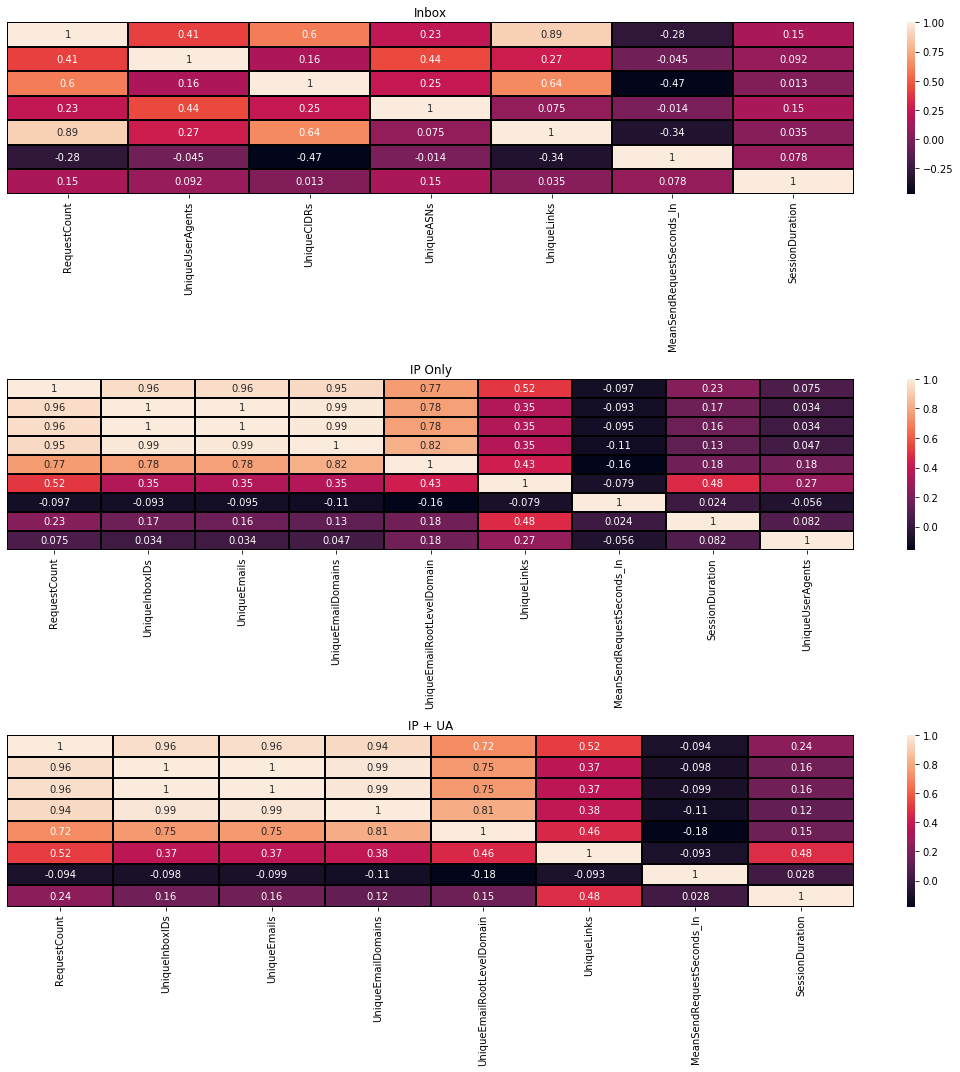

In [19]:
f = plt.figure(figsize=(15, 15))    
gs = f.add_gridspec(3,1)
i = 0
    
for df_name, df in unsup_data.items():
    ax = f.add_subplot(gs[i])
    corr = df.corr()
    sns.heatmap(corr, 
        xticklabels=True,
        yticklabels=False, 
        linewidths=1,
        linecolor='black',
        annot=True)
    plt.title(df_name)   
    i += 1

plt.tight_layout()
plt.show()

## Covariance/Correlation
- **Email Hierarchy** - We did not include UniqueInboxIDs, UniqueEmails and UniqueEmailDomains counts in the Inbox session since they would always be 1.  But these columns in the IP and IP/UA sessions types did not show that these columns differentiated sessions since they are very highly correlated with the request count.  This does not mean that there is not value, especially if the BOTs are a small percent of the requests.
- **IP Hierarchy** - Like email hierarchy, the IP hierarchy only applies to the Inbox sessionization since nuniques would all be 1 for the IP based session.  But unlike the email hierarchy, the IP hierarchy does show mid range corrlations (0.16 to 0.64).  i.e. So their is some covariance, but not to the point the IP hiearchy features are near 100% corrlation.

## Explore PCA

We only have 7 to 8 features, so PCA might not prove to be needed.

In [20]:
def getPCA_Fit(df):
    pca = PCA()
    fit = pca.fit(df)
    return (pca, fit)

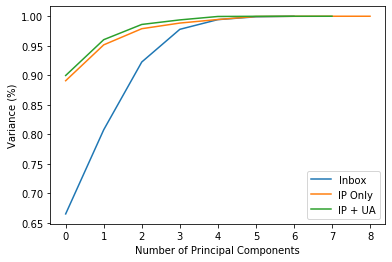

In [21]:
Inbox_pca, Inbox_fit = getPCA_Fit(df_Inbox_agg_unsup_s)
IP_pca, IP_fit = getPCA_Fit(df_IP_agg_unsup_s)
IPUA_pca, IPUA_fit = getPCA_Fit(df_IPUA_agg_unsup_s)

plt.figure()
plt.plot(np.cumsum(Inbox_pca.explained_variance_ratio_), label="Inbox")
plt.plot(np.cumsum(IP_pca.explained_variance_ratio_), label="IP Only")
plt.plot(np.cumsum(IPUA_pca.explained_variance_ratio_), label="IP + UA")
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance (%)') 
plt.legend()
plt.show()

# print("explained_variance_ratio\n Inbox:{}\n IP Only:{}\n IP + UA:{}".format(Inbox_fit.explained_variance_ratio_, IP_fit.explained_variance_ratio_, IPUA_fit.explained_variance_ratio_))

## Explore K-Means

In [22]:
kmeans_random_sate = 654657


def getKMeansInertias(dfs, max_clusters):
    result = defaultdict(list)
    for k in range(1,max_clusters):
        km = KMeans(n_clusters=k, random_state = kmeans_random_sate)
        
        for df_name, df in dfs.items():
            km = km.fit(df)
            result[df_name].append(km.inertia_.copy())
            
    return result

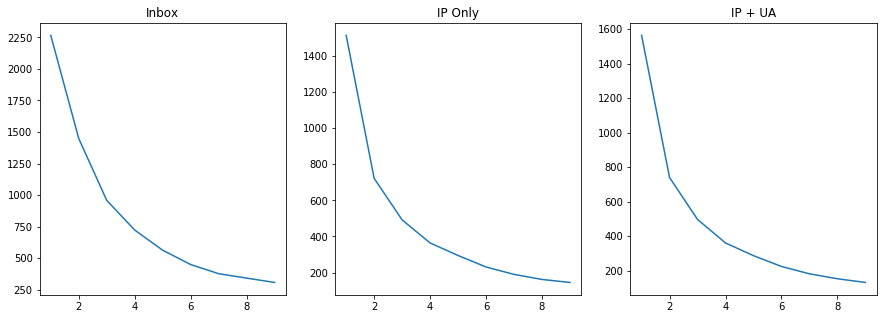

In [23]:
max_clusters = 10

k_means_inertia = getKMeansInertias(unsup_data, max_clusters)
cnt = len(k_means_inertia)
i=0

f = plt.figure(figsize=(15, 5))    
gs = f.add_gridspec(1,cnt)

for df_name, inertias in k_means_inertia.items():
    ax = f.add_subplot(gs[i])
    plt.plot(range(1,max_clusters),inertias)
    plt.title(df_name)   
    i += 1

plt.show()

# IP/UA Session

The covariance and K-Means inertia did not help much in differentiating between the 3 Session Types

The PCA variance % curves also show that IP and IP/UA sessions both only have a small number of significant principle components.  The Inbox session does have more PCs than the IP based sessions.  Since the number of features in all 3 is small, PCA is probably not of great benefit here. 

# Conclusions:

### Will use both Inbox sessions and one of the IP session. 
- **K-Means on IP** - Run K-Means one the IP based sessions
- **K-Means on Inbox** - Run K-Means on the Inbox session.
- **Append the Custer Results** - Add 2 new series to the raw DataFrame from both unsupervised learning.
- **Unsupervised on Appended Results**

## Since it is known that UserAgent is an import feature historically, we will use the IP/UA session

![alt text](Diagrams/MergingSessionDataFrames.png "MergingSessionDataFrames")

# K-Means IP/UA Session

### Looking at the variance % curve for this session, 3 clusters was choses as the best.


In [24]:
filename = 'C:/data/IPUA_KMeans.model'
build_new_model = True
if not path.exists(filename):
    build_new_model = True
    
if build_new_model:
    model = KMeans(n_clusters=3, random_state = kmeans_random_sate)
    model.fit(df_IPUA_agg_unsup_s)
    pickle.dump(model, open(filename, 'wb'))
else:
    model = pickle.load(open(filename, 'rb'))

    
labels = model.predict(df_IPUA_agg_unsup_s)

print(labels[:20])

[0 2 0 1 2 2 0 2 1 0 2 2 0 0 2 0 0 1 0 0]


#### Make sure the indexes and cardinality of the DataFrames and K-Means lables are a match

In [25]:
print("\
Index of groupby = {}\n\
Index of transformed = {}\n\
Index of KMeans Columns = {}"
      .format( 
              df_IPUA_agg.index.name,
              df_IPUA_agg_unsup.index.name, 
              df_IPUA_agg_unsup_s.index.name
             ))

print("\
Len of groupby = {}\n\
Len of transformed = {}\n\
Len of KMeans Columns = {}\n\
Len of lables = {}"
      .format( 
              len(df_IPUA_agg), 
              len(df_IPUA_agg_unsup), 
              len(df_IPUA_agg_unsup_s), 
              len(labels)
              ))

Index of groupby = IPUASessionID
Index of transformed = IPUASessionID
Index of KMeans Columns = IPUASessionID
Len of groupby = 70018
Len of transformed = 70018
Len of KMeans Columns = 70018
Len of lables = 70018


## Append the KMean Lables to the 2 IP group by DataFrames

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014F0A93B608>,
      dtype=object)

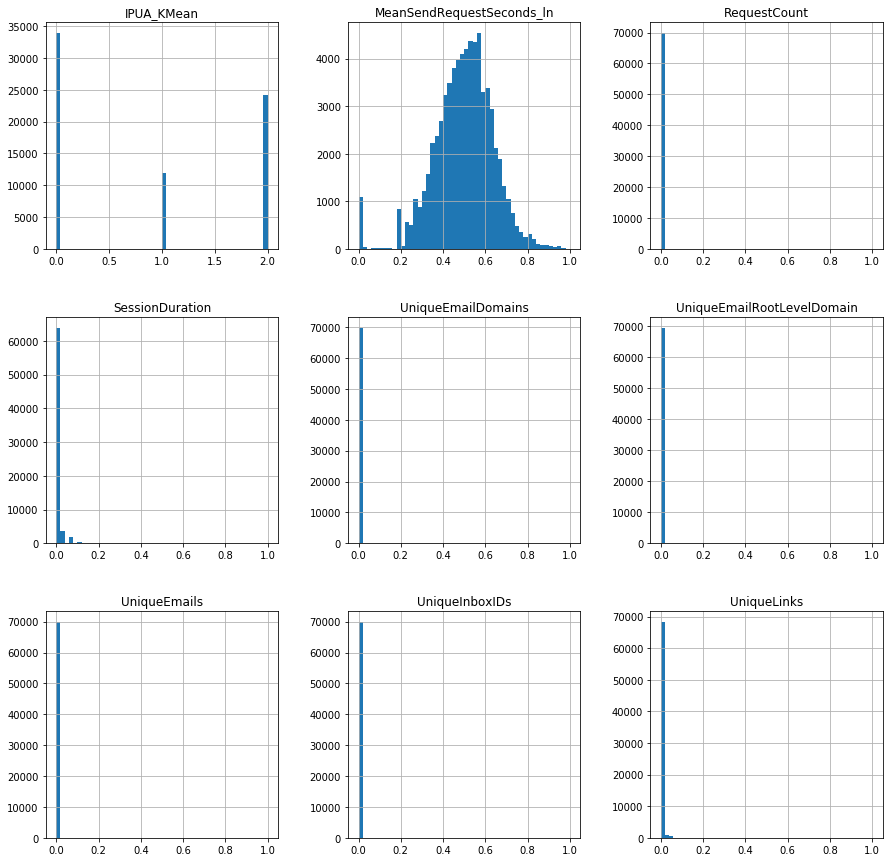

In [26]:
df_IPUA_agg['IPUA_KMean'] = labels #Origional Group By with additional agg columns
df_IPUA_agg_unsup['IPUA_KMean'] = labels #Normilized Aggregations
df_IPUA_agg_unsup_s['IPUA_KMean'] = labels #Not=Normilized Aggregations


df_IPUA_agg_unsup_s.hist(figsize=(15,15), bins=50)

## Build visualizations to manually inspect effectiveness of clusters

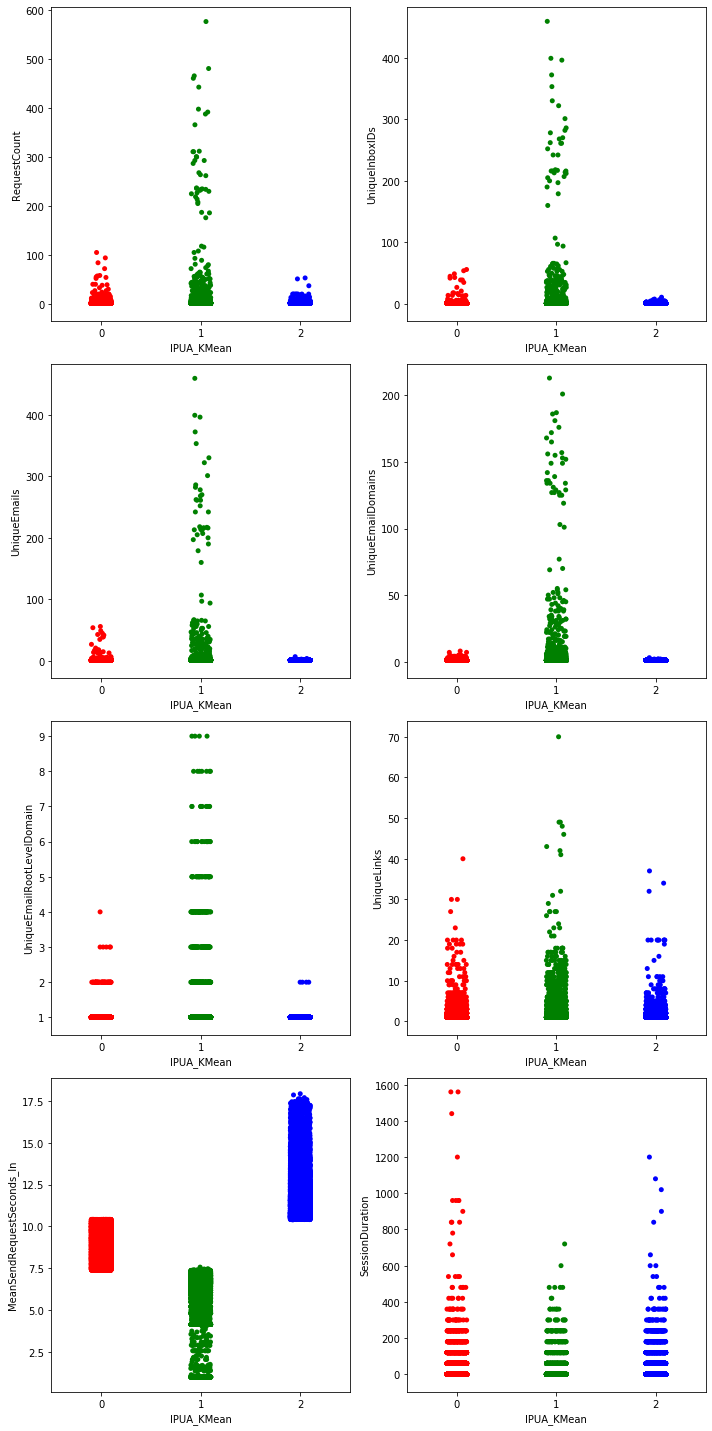

In [27]:
palette = {0:'r', 1:'g',2:'b'}
i = 0
j = 0
row_count = len(IPUA_unsup_columns) // 2
f = plt.figure(figsize=(10, 20))
gs = f.add_gridspec(row_count, 2)

for feature in IPUA_unsup_columns:
    ax = f.add_subplot(gs[i, j])
    sns.stripplot(x='IPUA_KMean', y=feature, palette=palette, data=df_IPUA_agg)
    if j == 1:
        j = 0
        i += 1
    else:
        j += 1

f.tight_layout()
plt.show()

### Label 1 stands out, esplishely in UniqueEmails and RequestCount
### Low UserAgent to RequestCount ratios for labels 1 and 4

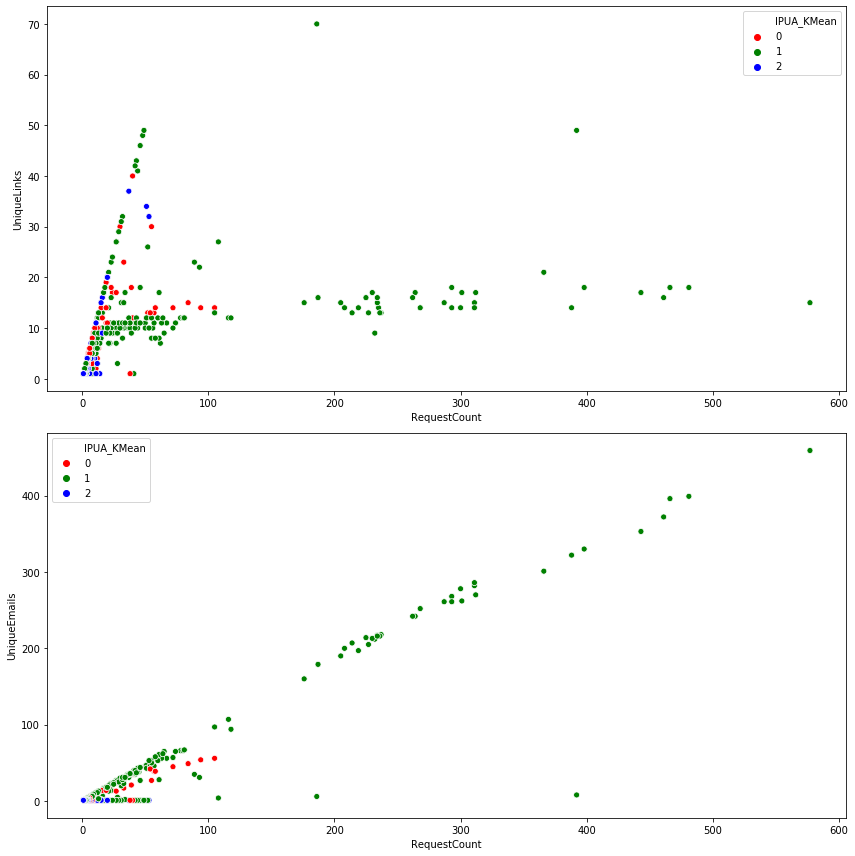

In [28]:
f = plt.figure(figsize=(12, 12))
gs = f.add_gridspec(2, 1)

ax = f.add_subplot(gs[0])
sns.scatterplot(y='UniqueLinks', x='RequestCount', hue='IPUA_KMean', palette=palette, data=df_IPUA_agg)

ax = f.add_subplot(gs[1])
sns.scatterplot(y='UniqueEmails', x='RequestCount', hue='IPUA_KMean', palette=palette, data=df_IPUA_agg)

f.tight_layout()
plt.show()

# Merge the K-Means labels for IP GroupBy with original df

## Remember, so far we have been looking at the group by DataFrame

### Now that we merged the K-Mean Lables into the raw date, we will see different cardinality since many requests were rolled up in teh group by

In [29]:
df = botDataSet.df
df_IPUA_clusters = pd.merge(df, df_IPUA_agg['IPUA_KMean'], on="IPUASessionID")
df_IPUA_clusters.head(2)

,InboxID,Company,List,Campaign,RequestType,SendDate,RequestDate,Link,IPAddress,UserAgent,AS Name,AS Number,CIDR Range,UserID,DomainID,EmailDomain,EmailRootLevelDomain,CountryCode,RegionCode,PostalCode,Lat,Long,OlsonName,SendRequestSeconds,SendRequestSeconds_ln,InboxSessionID,IPSessionID,IPUASessionID,IPUA_KMean
0,{582CF80F-649D-3184-ECE6-6EC82905B7CA},{30ADEAEA-4CB8-2254-1AD2-0D76721A3895},{E46FC402-5D7C-CB5B-0341-30AC5C9E30C6},{2DFC70F3-E099-652B-A336-E7A215899841},Click,2020-01-16 08:48:00,2020-01-16 09:00:00,{6F54316F-90F6-D7DB-F849-FF38B2507100},{64386B36-2523-58A3-518D-168C6A876DDA},{525CA1C0-D81A-8150-057B-F4E020CEA2D5},Unknown,Unknown,{14392925-2BAF-FC72-0602-9DB674D6E74D},{760483EB-5DBF-EFF3-EB13-109FD84ACA98},{81ADDE0D-9AB5-FC9D-B4ED-DE1A5256587F},{68F1F17F-F779-4BA9-C916-BD41710E6088},.gov,US,AL,35801,34.74939,-86.595892,America/Chicago,720,6.583019,-2424931345893956306,-8527355887580915924,2373821329628466554,1
1,{426C37ED-B9CB-5B33-68DC-31F0051BD0EF},{0AE65560-B4B1-A550-2E73-F2FEA47196C3},{503F63B5-B948-2BDE-D53B-6649A3FCCED6},{BE978D71-080F-A86A-A0C6-42BCCE18AD78},Click,2020-01-16 07:26:00,2020-01-16 09:00:00,{AD7F3EE6-4C42-29EC-7D8D-4C844E1081A2},{A1066275-4BAE-86E3-67DA-5EC5AB520098},{A2FB7436-7148-9DD5-E1E2-88F00433672F},Unknown,Unknown,{14392925-2BAF-FC72-0602-9DB674D6E74D},{74935A7A-14BD-170E-F109-C624004B02A1},{BD7BB2F9-F722-4FBC-CF83-B422B71E223B},{B5C5F013-913E-CA98-0570-B78F239A853C},.com,US,OK,74006,36.785605,-95.809941,America/Chicago,5640,8.638121,6335848840699161683,-1937994678177521444,-3252940474526944677,0


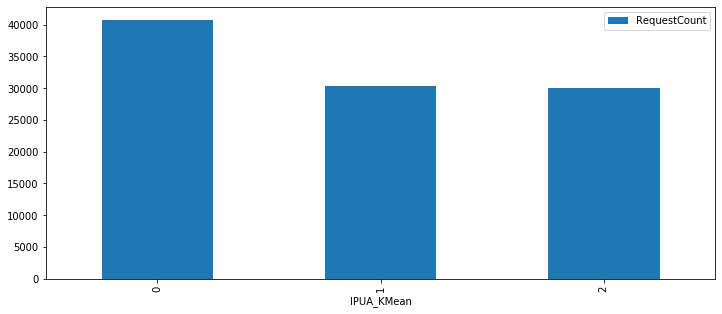

In [30]:
p= pd.DataFrame(df_IPUA_clusters.groupby(['IPUA_KMean'])['InboxID'].count())
p = p.unstack(0, )
p = p.reset_index('IPUA_KMean')
p.columns = ['IPUA_KMean', 'RequestCount']
p.plot.bar('IPUA_KMean', 'RequestCount', figsize=(12,5))

In [31]:
nunique_columns = [ 'InboxID',
                    'Company',
                    'List',
                    'Campaign',
                    'Link',
                    'IPAddress',
                    'UserAgent',
                    'AS Name',
                    'AS Number',
                    'CIDR Range',
                    'EmailDomain',
                    'EmailRootLevelDomain']
gb = df_IPUA_clusters.groupby(['IPUA_KMean'])[nunique_columns].nunique()
gb=gb.transpose()
gb

IPUA_KMean,0,1,2
InboxID,29768,11599,20423
Company,25,24,27
List,81,69,90
Campaign,350,292,913
Link,2120,1794,4102
IPAddress,28859,9932,20206
UserAgent,2472,1138,2305
AS Name,24,23,22
AS Number,25,24,23
CIDR Range,711,421,578


## Show distribution of these labels across the AS Names

In [32]:
def groupByPivot(group_column_top, group_column_left, count_column):
    gb = df_IPUA_clusters.groupby([group_column_top, group_column_left])[count_column].count()
    gb.fillna(0, inplace=True)
    gb = gb.unstack(0)
    gb.fillna(0, inplace=True)
    gb['All'] = gb[0] + gb[1] + gb[2]
    gb.sort_values('All', ascending=False, inplace=True)
    return gb

In [33]:
groupByPivot('IPUA_KMean', 'AS Name','InboxID')

IPUA_KMean,0,1,2,All
AS Name,,,,
Unknown,31753.0,10636.0,24639.0,67028.0
"Amazon.com, Inc.",2383.0,17308.0,558.0,20249.0
AT&T Mobility LLC,3074.0,782.0,2139.0,5995.0
"MCI Communications Services, Inc. Verizon Business",949.0,353.0,683.0,1985.0
"T-Mobile USA, Inc.",647.0,151.0,442.0,1240.0
"CenturyLink Communications, LLC",415.0,98.0,319.0,832.0
TELUS Communications Inc.,236.0,142.0,257.0,635.0
Google LLC,325.0,98.0,209.0,632.0
"Comcast Cable Communications, LLC",265.0,141.0,167.0,573.0


In [34]:
groupByPivot('IPUA_KMean', 'AS Number','InboxID')

IPUA_KMean,0,1,2,All
AS Number,,,,
Unknown,31753.0,10636.0,24639.0,67028.0
16509,299.0,15465.0,228.0,15992.0
20057,3074.0,782.0,2139.0,5995.0
14618,2084.0,1843.0,330.0,4257.0
701,949.0,353.0,683.0,1985.0
21928,647.0,151.0,442.0,1240.0
209,415.0,98.0,319.0,832.0
852,236.0,142.0,257.0,635.0
15169,325.0,98.0,209.0,632.0


In [35]:
groupByPivot('IPUA_KMean', 'CIDR Range','InboxID').head(20)

IPUA_KMean,0,1,2,All
CIDR Range,,,,
{14392925-2BAF-FC72-0602-9DB674D6E74D},31753.0,10636.0,24639.0,67028.0
{4ED21F0C-8573-052A-670B-E4D315133AF5},70.0,6406.0,44.0,6520.0
{7EF79BFD-BC3A-903D-C2BD-F5E295ACF4DE},6.0,2145.0,1.0,2152.0
{6194D26B-CF4C-CA86-F018-CDE54FED8393},751.0,206.0,526.0,1483.0
{855313BB-3482-1ADA-36A8-5D073B29C265},3.0,1398.0,0.0,1401.0
{7E737FAE-7868-5BE1-84B6-EA9011F3B32E},124.0,1101.0,2.0,1227.0
{9DA7FFE3-A644-988D-A6E7-0D6305395B19},649.0,157.0,412.0,1218.0
{F9164193-183A-7A69-1AE7-25BD6243ED72},20.0,1162.0,20.0,1202.0
{6893DEE9-A105-29E9-F9D4-98B3411CF42B},21.0,980.0,38.0,1039.0


## After manual review the 5 labels against the non-anomized data:
### The follow labels can be applied:

### Save lables to csv file for manual analysis with raw non-anonymized data in SQL.

In [36]:
select_columns = ['IPAddress', 'IPUA_KMean']
output = df_IPUA_clusters[select_columns].copy()
output.drop_duplicates(inplace=True)
output.to_csv('C:/data/IP_KMean_Lables.csv')
output

,IPAddress,IPUA_KMean
0,{64386B36-2523-58A3-518D-168C6A876DDA},1
1,{A1066275-4BAE-86E3-67DA-5EC5AB520098},0
2,{38803023-2C94-66E7-EBCD-338792441922},1
3,{488DFBAF-A009-4C64-7335-F446A28D4ECB},0
4,{5633CFE0-E7D3-AAC1-827B-C9D090299B06},1
...,...,...
101052,{3BD44551-CF8A-2327-CB09-31D5B06430B6},1
101054,{696CE8D3-9147-0578-C17D-73F3986F36E4},2
101055,{963F3C1D-CC68-123D-8EB9-26A2C11F8ECE},2
101057,{DA84E0F5-84AE-1059-3D4C-B4FF68AC1632},0
